# Q3
#### How diverse the directors are in their character choices ? 
#### Can we find very successful directors that always use the same type of characters or others that vary a lot in their personas choices ?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import entropy

from helpers.readers import read_dataframe
DATA_PATH = './generated/annotations_2023/'

# Load dataset nedded

In [2]:
character_movie_directors=pd.read_parquet(os.path.join(DATA_PATH, "character_movie_directors.parquet"), engine='pyarrow')

In [6]:
character_movie_directors.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Character name,tconst,directors,freebase,imdb,movieid_charactername,topic,topic_dist
0,2238856,/m/06yc6v,Me and You and Everyone We Know,Andrew,tt0415978,nm0432380,/m/06yc6v,tt0415978,2238856_Andrew,26,"[0.01000000000000015, 0.01000000000000015, 0.0..."
1,2238856,/m/06yc6v,Me and You and Everyone We Know,Heather,tt0415978,nm0432380,/m/06yc6v,tt0415978,2238856_Heather,31,"[0.245870487647632, 0.005000000000000419, 0.00..."
2,2238856,/m/06yc6v,Me and You and Everyone We Know,Pam,tt0415978,nm0432380,/m/06yc6v,tt0415978,2238856_Pam,30,"[0.010000000000000016, 0.010000000000000016, 0..."
3,156558,/m/014k4y,Baby Boy,Yvette,tt0255819,nm0005436,/m/014k4y,tt0255819,156558_Yvette,31,"[0.0012500000000002947, 0.0012500000000002947,..."
4,156558,/m/014k4y,Baby Boy,Jody,tt0255819,nm0005436,/m/014k4y,tt0255819,156558_Jody,31,"[0.0008695652173914489, 0.0008695652173914489,..."


In [13]:
# Check for missing values
print(character_movie_directors.isnull().sum())

Wikipedia movie ID       0
Freebase movie ID        0
Movie name               0
Character name           0
tconst                   0
directors                0
freebase                 0
imdb                     0
movieid_charactername    0
topic                    0
topic_dist               0
dtype: int64


In [15]:
# Load dataset of the name of directors
imdb_name = read_dataframe(name='imdb/names')

In [16]:
imdb_name.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0053137,tt0050419,tt0072308,tt0031983"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0037382,tt0075213,tt0038355,tt0117057"
2,nm0000003,Brigitte Bardot,1934,<NA>,"actress,soundtrack,music_department","tt0057345,tt0049189,tt0056404,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0077975,tt0080455,tt0072562,tt0078723"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0083922,tt0050976,tt0069467"


In [19]:
# !pip install memory_profiler
# install and load memory_profiler to use %memit, use %whos to see what's in memory
%reload_ext memory_profiler
%memit
import gc

del imdb_name

gc.collect()
%memit

peak memory: 3775.04 MiB, increment: 0.05 MiB
peak memory: 3775.25 MiB, increment: 0.19 MiB


In [18]:
# Add primaryName to character_movie_directors
character_movie_directors = character_movie_directors.merge(imdb_name[['nconst', 'primaryName']], left_on='directors', right_on='nconst', how='left')
display(character_movie_directors.head())

,Wikipedia movie ID,Freebase movie ID,Movie name,Character name,tconst,directors,freebase,imdb,movieid_charactername,topic,topic_dist,nconst,primaryName
0,2238856,/m/06yc6v,Me and You and Everyone We Know,Andrew,tt0415978,nm0432380,/m/06yc6v,tt0415978,2238856_Andrew,26,"[0.01000000000000015, 0.01000000000000015, 0.0...",nm0432380,Miranda July
1,2238856,/m/06yc6v,Me and You and Everyone We Know,Heather,tt0415978,nm0432380,/m/06yc6v,tt0415978,2238856_Heather,31,"[0.245870487647632, 0.005000000000000419, 0.00...",nm0432380,Miranda July
2,2238856,/m/06yc6v,Me and You and Everyone We Know,Pam,tt0415978,nm0432380,/m/06yc6v,tt0415978,2238856_Pam,30,"[0.010000000000000016, 0.010000000000000016, 0...",nm0432380,Miranda July
3,156558,/m/014k4y,Baby Boy,Yvette,tt0255819,nm0005436,/m/014k4y,tt0255819,156558_Yvette,31,"[0.0012500000000002947, 0.0012500000000002947,...",nm0005436,John Singleton
4,156558,/m/014k4y,Baby Boy,Jody,tt0255819,nm0005436,/m/014k4y,tt0255819,156558_Jody,31,"[0.0008695652173914489, 0.0008695652173914489,...",nm0005436,John Singleton


# How diverse the directors are in their character choices ? 

In [39]:
# Group by directors
directors_group = character_movie_directors.groupby('directors').agg({'Wikipedia movie ID': lambda x: list(x), 'Freebase movie ID': lambda x: list(x), 'Movie name': lambda x: list(x), 'Character name': lambda x: list(x), 'topic': lambda x: list(x), 'tconst': lambda x: list(x),'primaryName':lambda x: list(x)})
# character_movie_directors_group.head(3)
print('There are {} unique directors who has the chracter type information'.format(directors_group.shape[0]))

There are 6941 unique directors who has the chracter type information


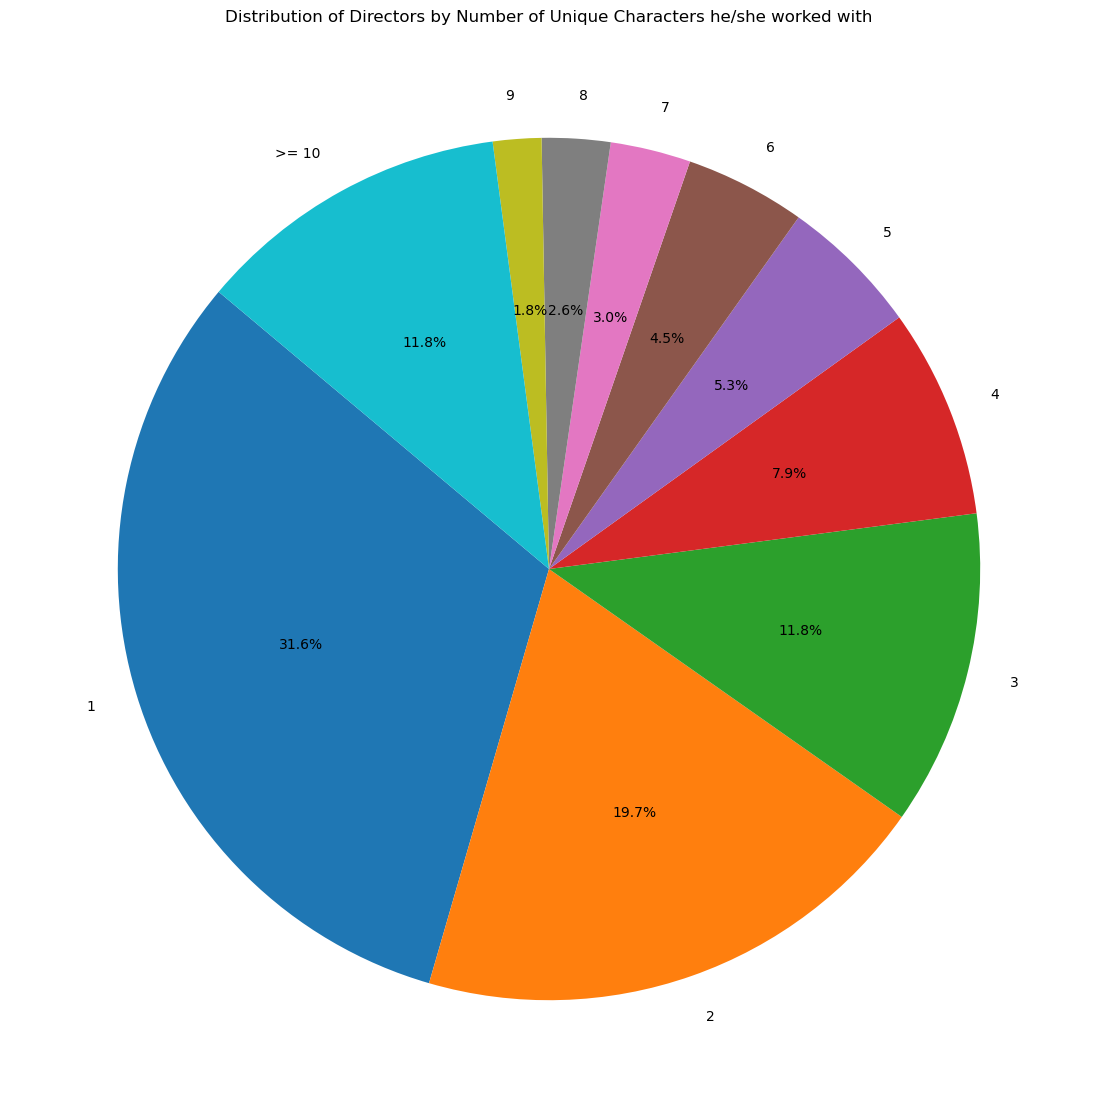

In [40]:
# Calculate the number of unique characters for each director
unique_characters = character_movie_directors.groupby('directors')['topic'].nunique()

# Count the number of directors for each unique number of characters
directors_by_unique_count = unique_characters.value_counts()

# Group together directors with more than 10 unique characters
threshold = 10
large_counts = directors_by_unique_count[directors_by_unique_count.index >= threshold]
directors_by_unique_count = directors_by_unique_count.drop(large_counts.index)
directors_by_unique_count[f'>= {threshold}'] = large_counts.sum()

# Create a pie chart to show the distribution with a custom color map
labels = directors_by_unique_count.index.astype(str)
sizes = directors_by_unique_count.values
colors = plt.cm.tab10(range(len(labels)))

plt.figure(figsize=(14, 14))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Directors by Number of Unique Characters he/she worked with')
plt.show()

Let's have a close look of ten directors with the highest diversity

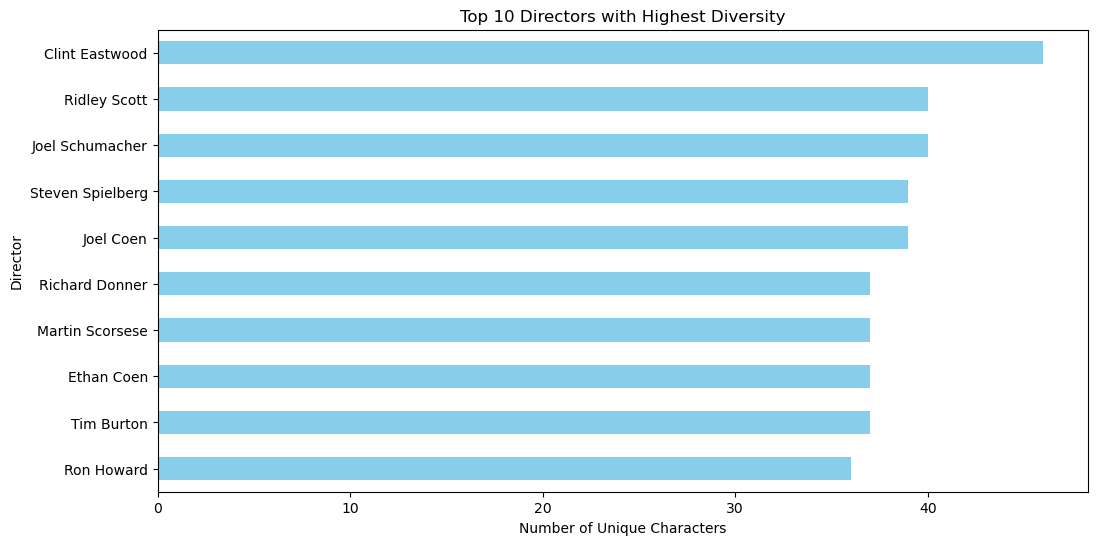

In [50]:
# Calculate the number of unique characters for each director
unique_characters = character_movie_directors.groupby('directors')['topic'].nunique()

# Map director IDs to corresponding 'primaryName'
directors_mapping = character_movie_directors.set_index('directors')['primaryName'].to_dict()
unique_characters.index = unique_characters.index.map(directors_mapping)

# Sort directors based on diversity
sorted_directors = unique_characters.sort_values()

# Visualize the ten directors with the highest diversity
plt.figure(figsize=(12, 6))
sorted_directors.tail(10).plot(kind='barh', color='skyblue')
plt.title('Top 10 Directors with Highest Diversity')
plt.xlabel('Number of Unique Characters')
plt.ylabel('Director')
plt.show()

From the above pie chart, we can observe that almost half of the directors only worked with one or two chractor type. However, this observation might be subject to the influence of the total number of movies each director has undertaken. To achieve a more precise quantification of the diversity in directors' character choices, we need a more refined quantitative method.

#### Quantify diversity
For quantify diversity, we calculate the Shannon diversity index for each director based on the distribution of chracter types in their movies. Higher entropy values indicate grater diversity.

In [7]:
diversity_counts = character_movie_directors.groupby(['directors', 'topic']).size().reset_index(name='Counts')

In [ ]:
director_diversity = character_movie_directors.groupby('directors')['topic'].apply(lambda x: entropy(x.value_counts()))

In [4]:
diversity_counts

,directors,topic,Counts
0,nm0000005,7,1
1,nm0000005,15,1
2,nm0000005,30,3
3,nm0000005,31,2
4,nm0000005,36,1
...,...,...,...
30488,nm9712682,0,1
30489,nm9916471,2,1
30490,nm9916471,43,1
30491,nm9916712,2,1
